In [1]:
import pandas as pd
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import seaborn as sns
import tensorflow_text
import numpy as np
from tensorflow.keras.layers import Average
import tensorflow_hub as hub
import tensorflow as tf
import nltk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report , accuracy_score , precision_score , recall_score , f1_score
from sklearn.metrics import confusion_matrix
import seaborn
import gpt_2_simple as gpt2

In [12]:
# Read data
df = pd.read_csv('mtsamples.csv')

df = df[df['medical_specialty'].str.contains('(?!Cosmetic / Plastic Surgery)Surgery|Consult - History and Phy.|Cardiovascular / Pulmonary|Orthopedic|Radiology|General Medicine|Gastroenterology|Neurology|SOAP / Chart / Progress Notes|Obstetrics / Gynecology|Urology|Discharge Summary|ENT - Otolaryngology|Neurosurgery|Hematology - Oncology|Ophthalmology|Nephrology|Emergency Room Reports|Pediatrics - Neonatal|Pain Management', na=False, regex=True)]

# Drop unwanted column
df.drop(['Unnamed: 0' , 'description' , 'sample_name' , 'keywords'] , axis = 1 , inplace = True)

# Show data
df

,medical_specialty,transcription
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
7,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
9,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
11,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."
...,...,...
4972,Cardiovascular / Pulmonary,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden..."
4973,Cardiovascular / Pulmonary,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES..."
4974,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , The patient is a..."
4975,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-..."


medical_specialty     0
transcription        32
dtype: int64


Number of classes: 21
Class frequency:
 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Cosmetic / Plastic Surgery         27
Name: medical_specialty, dtype: int64


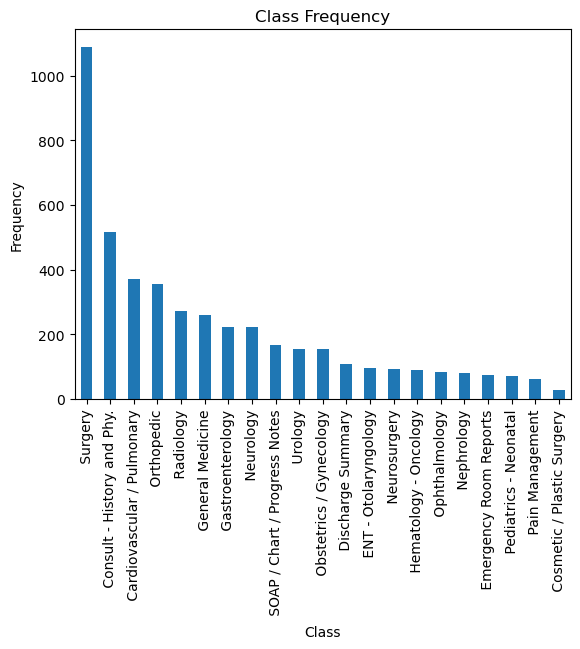

In [3]:
# Chack if there is a null data in df
print(df.isnull().sum())

# Drop the rows that have a null data
df.dropna(inplace=True)

print('')
print('')

# Determine the number of classes
num_classes = len(set(df['medical_specialty']))
print(f'Number of classes: {num_classes}')

# Count the frequency of each class
class_counts = df['medical_specialty'].value_counts()
print(f'Class frequency:')
print(class_counts)

# Plot the class frequency
class_counts.plot(kind='bar', title='Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [13]:
def preprocess_text(text, stem=True, lemmatize=True):
    # Convert the text to lower case
    text = str(text)
    text = text.lower()
    
    # Remove links
    text = re.sub(r'http\S+', '', text)
    
    # Replace symbols with empty spaces
    text = re.sub(r'[^\w\s]', ' ', text)
        
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    
    # Remove non-English words and characters
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Lemmatize the tokens
    if lemmatize:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join the tokens back into a single string
    text = " ".join(tokens)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [14]:
# Get the list of stopwords
stop_words = set(stopwords.words('english'))

# Create a Porter stemmer
stemmer = PorterStemmer()

# Create a WordNet lemmatizer
lemmatizer = WordNetLemmatizer()
# Preprocess the 'transcription' column
df['transcription_clean'] = df['transcription'].apply(preprocess_text)


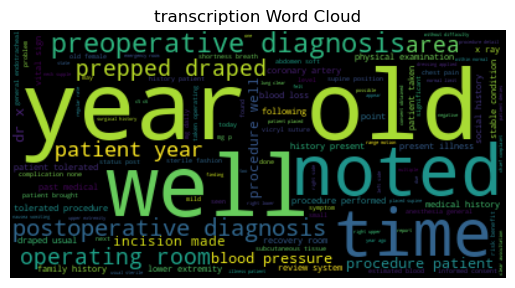

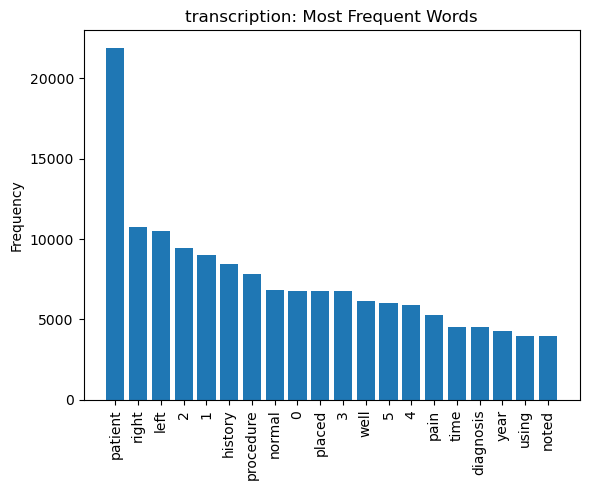

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Join the cleaned transcription data into a single string
transcription_string = ' '.join([''.join(transcription) for transcription in df['transcription_clean']])

# Create a word cloud
wordcloud = WordCloud().generate(transcription_string)

# Plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('transcription Word Cloud')
plt.show()

# Count the frequency of each word
word_counts = {}
for word in transcription_string.split():
    if word in word_counts:
        word_counts[word] += 1
    else:
        word_counts[word] = 1

# Sort the word counts in descending order
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Plot the top 20 most frequent words
top_words = [word for word, count in sorted_word_counts[:20]]
top_counts = [count for word, count in sorted_word_counts[:20]]

plt.bar(top_words, top_counts, align='center')
plt.title('transcription: Most Frequent Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


In [7]:
labels = df['medical_specialty'].value_counts().index[0:].values

In [8]:
from transformers import pipeline

model_name = "gpt2"
generator = pipeline("text-generation", model=model_name, tokenizer=model_name)

def generate_text(prompt , max_length = 100):
    generated_text = generator(prompt, max_length=max_length, num_return_sequences=1)
    return generated_text[0]['generated_text']


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")



new_data = pd.DataFrame(columns=["medical_specialty" , "transcription_clean"])
# word_counts = df[df['medical_specialty'] == label]["transcription_clean"].str.split().apply(len)

for label in labels:

    n = len(df[df['medical_specialty'] == label])
    n_index = df[df['medical_specialty'] == label].index.tolist()
   





    while n < 500:
        for Index in n_index:

            try:   
                if n < 500:
                    print(Index)
                    
                    text = df['transcription_clean'][Index]
                    tokens = tokenizer.tokenize(text)
                    token_count = len(tokens)

                    generate = generate_text( text , token_count + 100)
                    new_data = new_data.append( {"medical_specialty":label , "transcription_clean" : generate}, ignore_index = True)
        
                    n = n + 1

                else:

                    break

            except:
                print("hi")



    

In [17]:
df.drop(['transcription'] , axis = 1 , inplace=True)

In [15]:
FullData = pd.read_csv("data.csv")
FullData.drop(["Unnamed: 0"] , axis = 1 , inplace=True)
FullData = FullData.sample(frac=1).reset_index(drop=True)
FullData

,medical_specialty,transcription_clean
0,Pediatrics - Neonatal,chief complaint congestion cough history prese...
1,Pediatrics - Neonatal,flexible bronchoscopy flexible bronchoscopy pe...
2,SOAP / Chart / Progress Notes,reason visit preop evaluation regarding gastri...
3,Neurosurgery,preoperative diagnosis 1 cervical spinal steno...
4,Cosmetic / Plastic Surgery,preoperative diagnosis mammary hypertrophy bre...
...,...,...
6528,Pediatrics - Neonatal,informant dad phone transferred abcd memorial ...
6529,Pediatrics - Neonatal,history present illness patient 14 year old wh...
6530,Pediatrics - Neonatal,procedure newborn circumcision indication pare...
6531,General Medicine,discharge diagnosis 1 chronic obstructive pulm...


In [19]:
FullData = pd.concat([df , FullData])

FullData = FullData.sample(frac=1).reset_index(drop=True)

FullData

,medical_specialty,transcription_clean
0,Consult - History and Phy.,allowed condition lateral epicondylitis right ...
1,Discharge Summary,admitting diagnosis 1 bradycardia 2 dizziness ...
2,SOAP / Chart / Progress Notes,history present illness patient 41 year old wh...
3,Urology,preoperative diagnosis ectopic left testis pos...
4,Obstetrics / Gynecology,procedure performed modified radical mastectom...
...,...,...
11131,Ophthalmology,description operation patient brought operatin...
11132,Pediatrics - Neonatal,chief complaint 5 year old male present child ...
11133,Obstetrics / Gynecology,started period age 13 complaining three month ...
11134,Pediatrics - Neonatal,exam single frontal view chest history respira...


medical_specialty      0
transcription_clean    0
dtype: int64


Number of classes: 21
Class frequency:
 Surgery                          1103
 Consult - History and Phy.        516
 Gastroenterology                  506
 Obstetrics / Gynecology           505
 Urology                           502
 ENT - Otolaryngology              502
 Cardiovascular / Pulmonary        501
 Pain Management                   501
 Cosmetic / Plastic Surgery        500
 Nephrology                        500
 Neurosurgery                      500
 Ophthalmology                     500
 General Medicine                  500
 Radiology                         500
 Discharge Summary                 500
 Neurology                         500
 Hematology - Oncology             500
 Pediatrics - Neonatal             500
 Orthopedic                        500
 SOAP / Chart / Progress Notes     500
 Emergency Room Reports            500
Name: medical_specialty, dtype: int64


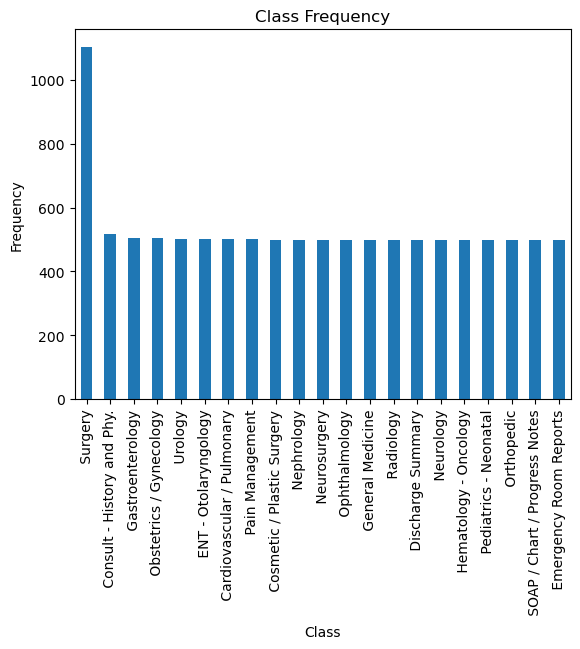

In [32]:
# Chack if there is a null data in df
print(FullData.isnull().sum())

# Drop the rows that have a null data
FullData.dropna(inplace=True)

print('')
print('')

# Determine the number of classes
num_classes = len(set(FullData['medical_specialty']))
print(f'Number of classes: {num_classes}')

# Count the frequency of each class
class_counts = FullData['medical_specialty'].value_counts()
print(f'Class frequency:')
print(class_counts)

# Plot the class frequency
class_counts.plot(kind='bar', title='Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [46]:
edit_data = FullData[FullData['medical_specialty'] != " Surgery"]
edit_data = edit_data[edit_data['medical_specialty'] != " Cosmetic / Plastic Surgery"]
edit_data = edit_data[edit_data['medical_specialty'] != " Discharge Summary"]
edit_data = edit_data[edit_data['medical_specialty'] != " Gastroenterology"]
edit_data = edit_data[edit_data['medical_specialty'] != " Obstetrics / Gynecology"]


In [47]:
edit_data['medical_specialty'].value_counts()

 Consult - History and Phy.       516
 Urology                          502
 ENT - Otolaryngology             502
 Pain Management                  501
 Cardiovascular / Pulmonary       501
 SOAP / Chart / Progress Notes    500
 Orthopedic                       500
 Pediatrics - Neonatal            500
 Hematology - Oncology            500
 Neurology                        500
 Radiology                        500
 General Medicine                 500
 Ophthalmology                    500
 Neurosurgery                     500
 Nephrology                       500
 Emergency Room Reports           500
Name: medical_specialty, dtype: int64

In [48]:
from simpletransformers.language_representation import RepresentationModel

model = RepresentationModel(
        model_type="bert",
        model_name="bert-base-uncased",
        use_cuda=False
    )


word_vectors = model.encode_sentences(edit_data['transcription_clean'], combine_strategy=None)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTextRepresentation: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTextRepresentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTextRepresentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
word_vectors.shape

(8022, 128, 768)

In [50]:
# print the shape for 'transcription_embedding'
# print(f"transcription_embedding shape : {transcription_embedding.shape}")

# Split the data to a train and test 
x_train , x_test , y_train , y_test = train_test_split(word_vectors , edit_data["medical_specialty"] 
                                                       , shuffle=True
                                                       , train_size=0.75)


# print the shape for x_train , x_test , y_train , y_test
print(f"x_train shape : {x_train.shape}")
print(f"x_test shape : {x_test.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"y_test shape : {y_test.shape}")


# Labeling
LB = LabelEncoder()
y_train_label = LB.fit_transform(y_train)
y_test_label = LB.transform(y_test)
# OneHotEncodeing
y_trainReady = to_categorical(y_train_label)
y_testReady = to_categorical(y_test_label)

print(f'y_trainReady shape : {y_trainReady.shape}')
print(f'y_testReady shape : {y_testReady.shape}')


x_train shape : (6016, 128, 768)
x_test shape : (2006, 128, 768)
y_train shape : (6016,)
y_test shape : (2006,)
y_trainReady shape : (6016, 16)
y_testReady shape : (2006, 16)


In [1]:
Input_tensor= tf.keras.layers.Input(shape = (128, 768))
cnn = tf.keras.layers.Conv1D(filters = 128 , kernel_size = 2)(Input_tensor)
cnn = tf.keras.layers.BatchNormalization()(cnn)
cnn = tf.keras.layers.ReLU()(cnn)

tcn = tf.keras.layers.Conv1D(filters=128, kernel_size=2)(cnn)
tcn = tf.keras.layers.BatchNormalization()(tcn)
tcn = tf.keras.layers.ReLU()(tcn)

drop = tf.keras.layers.Dropout(0.2)(tcn)

tcn = tf.keras.layers.Conv1D(filters=128, kernel_size=2)(drop)
attention2 = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(tcn , tcn)
tcn = tf.keras.layers.BatchNormalization()(attention2)
tcn = tf.keras.layers.ReLU()(tcn)

AVG = tf.keras.layers.GlobalAvgPool1D()(tcn)

dense = tf.keras.layers.Dense(64 , activation='relu')(AVG)
output = tf.keras.layers.Dense(16 , activation = 'softmax')(dense)
model = tf.keras.Model(inputs = Input_tensor , outputs = output)


NameError: name 'tf' is not defined

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Data preprocessing
# train_datagen = ImageDataGenerator(rescale=1./255)
# train_generator = train_datagen.flow_from_directory(
#     'path/to/training_data',
#     target_size=(150, 150),
#     batch_size=32,
#     class_mode='binary'
# )

# # Train the model
# model.fit(train_generator, epochs=10)

# # Save the model
# model.save('human_animal_classifier.h5')


In [61]:
# Get Model summary
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 768)]   0           []                               
                                                                                                  
 conv1d_21 (Conv1D)             (None, 127, 128)     196736      ['input_8[0][0]']                
                                                                                                  
 batch_normalization_19 (BatchN  (None, 127, 128)    512         ['conv1d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_19 (ReLU)                (None, 127, 128)     0           ['batch_normalization_19[0]

In [62]:
# Compile and fiting the model

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

history = model.fit(x_train , y_trainReady,
          validation_data=(x_test , y_testReady),
          epochs=50)

Train on 6016 samples, validate on 2006 samples
Epoch 1/50
6016/6016 [==============================] - ETA: 0s - loss: 1.6212 - accuracy: 0.4940

d:\Anaconda\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6016/6016 [==============================] - 62s 10ms/sample - loss: 1.6212 - accuracy: 0.4940 - val_loss: 1.4345 - val_accuracy: 0.5449
Epoch 2/50
6016/6016 [==============================] - 62s 10ms/sample - loss: 1.0631 - accuracy: 0.6420 - val_loss: 1.4111 - val_accuracy: 0.5513
Epoch 3/50
6016/6016 [==============================] - 62s 10ms/sample - loss: 0.9228 - accuracy: 0.6787 - val_loss: 1.3262 - val_accuracy: 0.5663
Epoch 4/50
6016/6016 [==============================] - 61s 10ms/sample - loss: 0.8477 - accuracy: 0.6940 - val_loss: 0.9148 - val_accuracy: 0.6715
Epoch 5/50
6016/6016 [==============================] - 62s 10ms/sample - loss: 0.7715 - accuracy: 0.7196 - val_loss: 1.0347 - val_accuracy: 0.6685
Epoch 6/50
6016/6016 [==============================] - 62s 10ms/sample - loss: 0.7275 - accuracy: 0.7227 - val_loss: 0.9174 - val_accuracy: 0.6934
Epoch 7/50
6016/6016 [==============================] - 62s 10ms/sample - loss: 0.7022 - accuracy: 0.7314 - val_loss: 0.846

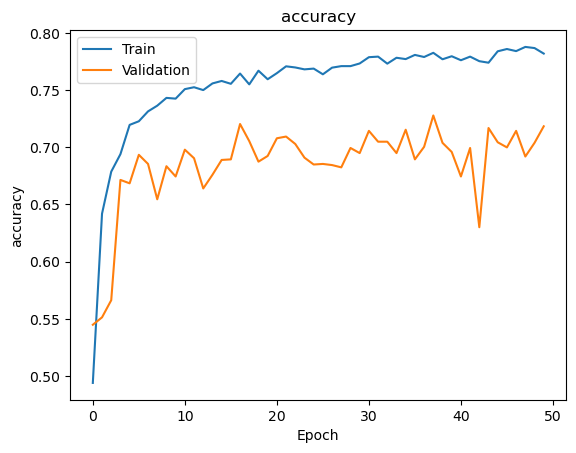

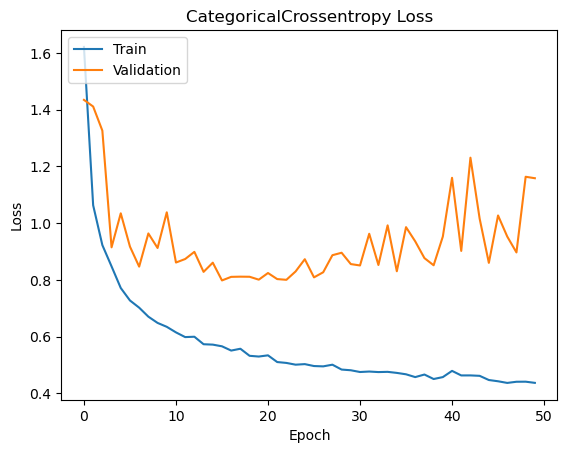

In [63]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation loss values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation mse values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('CategoricalCrossentropy Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


plot_training_history(history)

In [64]:
# Get model prediction
prediction = model.predict(x_test)

prediction = np.array(prediction)
prediction = np.argmax(prediction, axis = 1)
realy = np.argmax(y_testReady , axis = 1)

print(f"accuracy_score : {accuracy_score(realy , prediction)}")
print(f"precision_score : {precision_score(realy , prediction, average='micro')}")
print(f"recall_score : {recall_score(realy , prediction, average='micro')}")
print(f"f1_score : {f1_score(realy , prediction, average='micro')}")


d:\Anaconda\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


accuracy_score : 0.7183449651046859
precision_score : 0.7183449651046859
recall_score : 0.7183449651046859
f1_score : 0.718344965104686


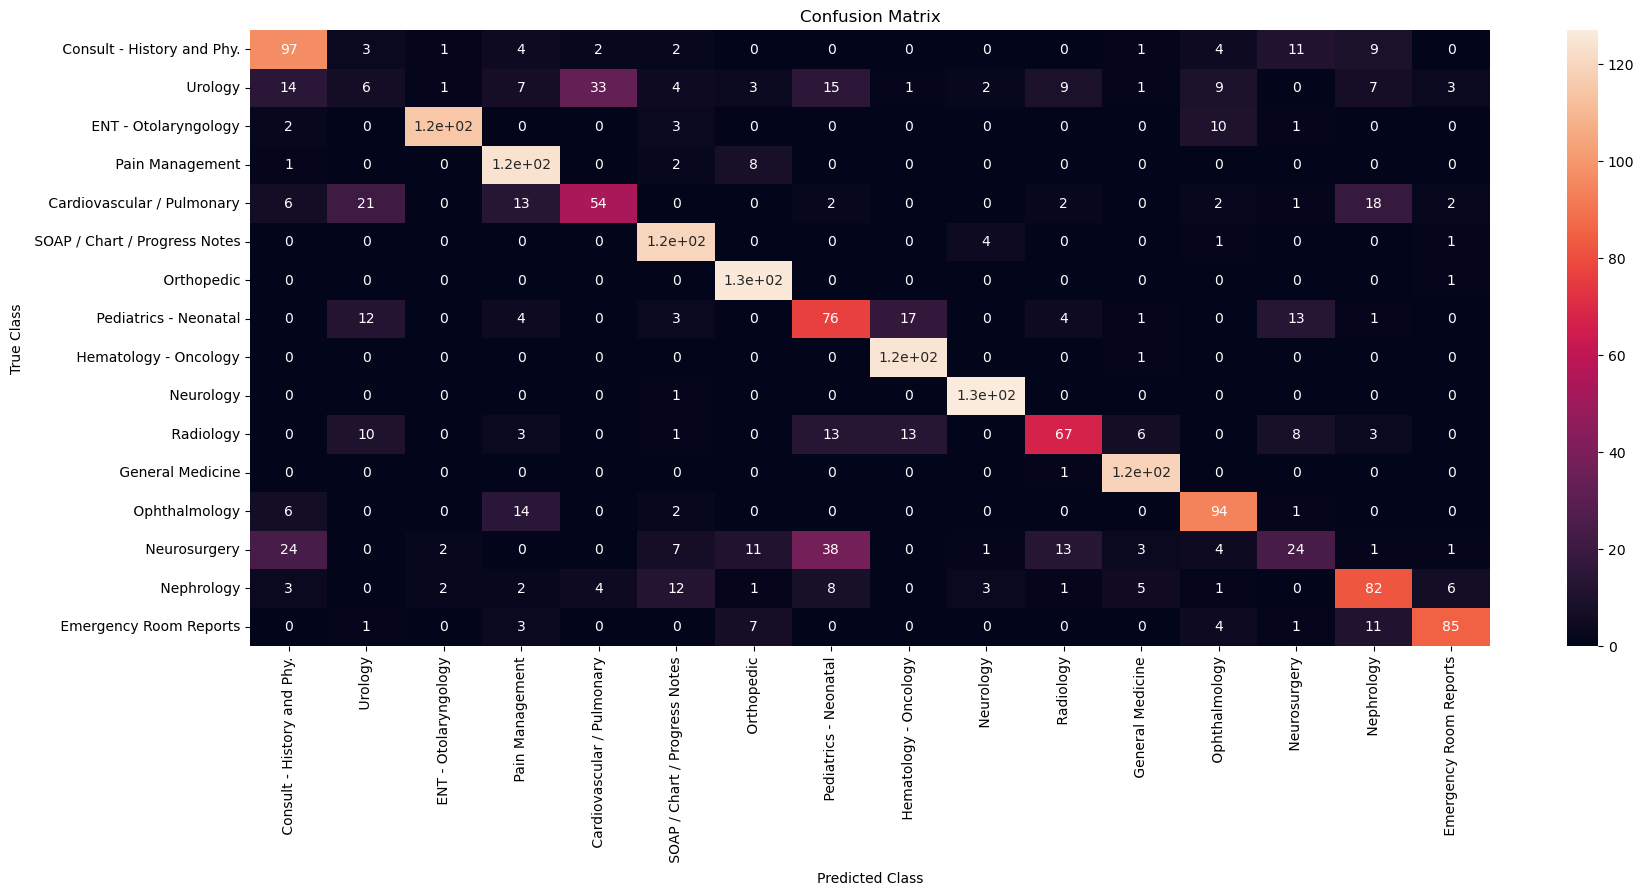

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the class names
class_names = edit_data['medical_specialty'].value_counts().index[0:].values  # Replace with your actual class names

# Compute confusion matrix
con = confusion_matrix(realy, prediction)

# Plot confusion matrix
plt.figure(figsize=(20, 8))
sns.heatmap(con, annot=True, fmt='.2g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()
